In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
app_train = pd.read_csv('data/application_train.csv')
app_test = pd.read_csv('data/application_test.csv')

In [3]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

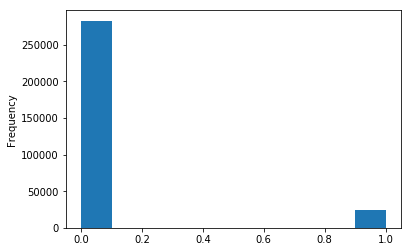

In [4]:
app_train['TARGET'].astype(int).plot.hist()

In [5]:
#app_train.isnull().sum()

In [6]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [7]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [8]:
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <=2:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            le_count +=1
print('%d columns were label encoded.' % le_count)    

3 columns were label encoded.


In [9]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [10]:
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test,join='inner',axis = 1)
app_train['TARGET'] = train_labels
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [11]:
(app_train['DAYS_EMPLOYED'] / -365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

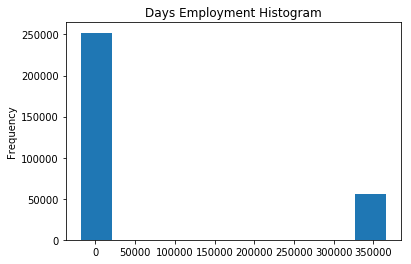

In [12]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')

In [13]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


In [14]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


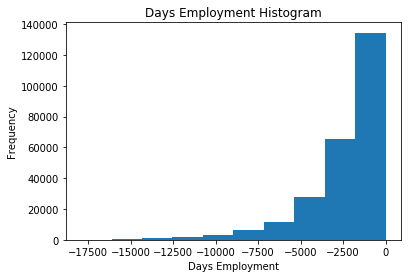

In [15]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [16]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 0 anomalies in the test data out of 48744 entries


In [17]:
correlations = app_train.corr()['TARGET'].sort_values()
correlations.tail()

REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

In [18]:
correlations.head()

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
Name: TARGET, dtype: float64

In [19]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982737

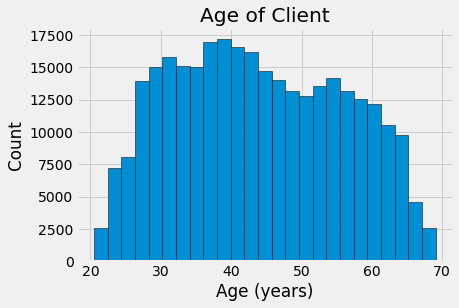

In [20]:
# Set the style of plots
plt.style.use('fivethirtyeight')
# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365.25, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

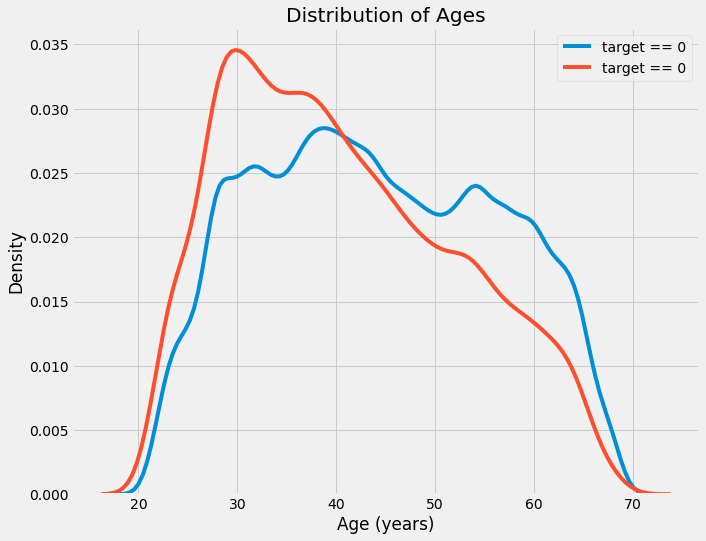

In [21]:
plt.figure(figsize = (10,8))
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH']/365, label = 'target == 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH']/365, label = 'target == 0')
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [22]:
age_data = app_train[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']/365.25

In [23]:
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.902806,"(25.0, 30.0]"
1,0,16765,45.900068,"(45.0, 50.0]"
2,0,19046,52.145106,"(50.0, 55.0]"
3,0,19005,52.032854,"(50.0, 55.0]"
4,0,19932,54.570842,"(50.0, 55.0]"
5,0,16941,46.381930,"(45.0, 50.0]"
6,0,13778,37.722108,"(35.0, 40.0]"
7,0,18850,51.608487,"(50.0, 55.0]"
8,0,20099,55.028063,"(55.0, 60.0]"
9,0,14469,39.613963,"(35.0, 40.0]"


In [24]:
age_data.groupby('YEARS_BINNED').mean().head()

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.122946,8536.397286,23.371382
"(25.0, 30.0]",0.111280,10161.525688,27.820741
"(30.0, 35.0]",0.102695,11863.320752,32.480002
"(35.0, 40.0]",0.089637,13716.573041,37.553930
"(40.0, 45.0]",0.078332,15506.340775,42.454047


In [25]:
ages = age_data.groupby('YEARS_BINNED').mean().reset_index()
plt.rcParams['figure.figsize'] = (15.0, 15.0)

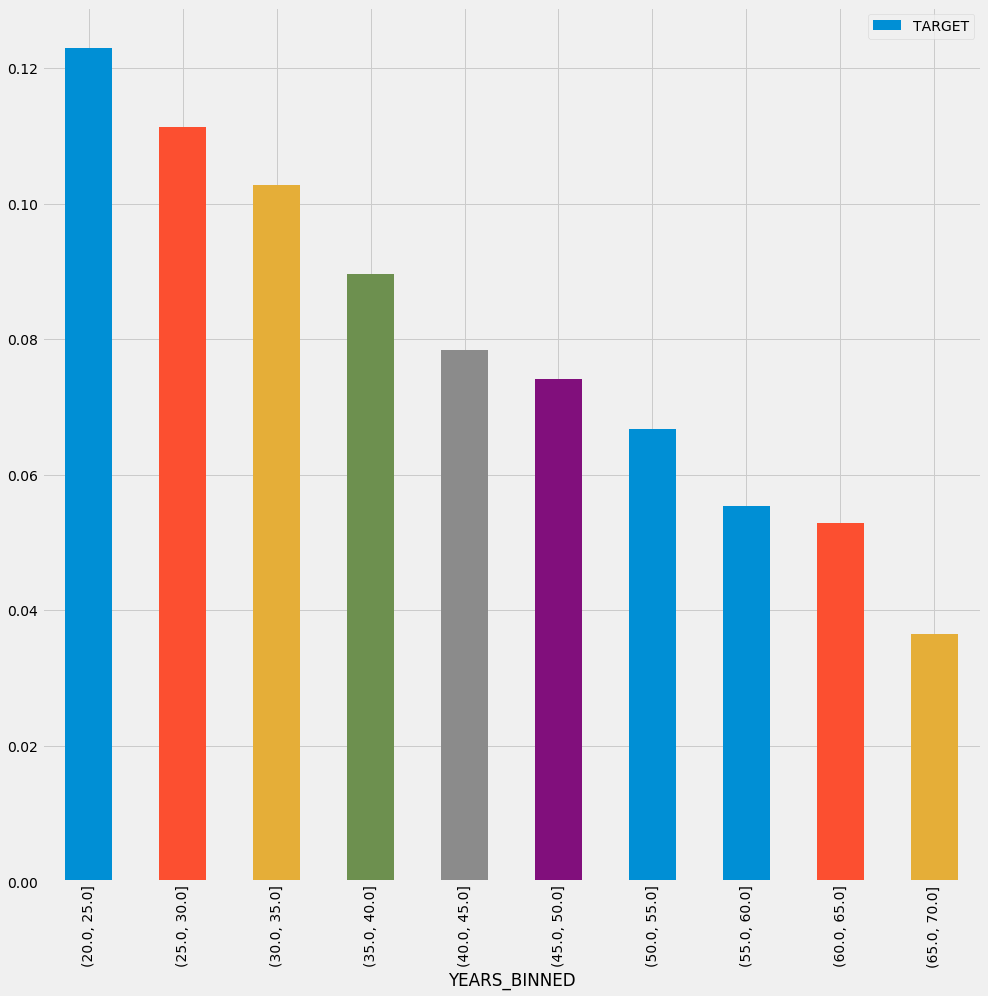

In [26]:
ages.plot.bar(x='YEARS_BINNED',y='TARGET')

In [27]:
ext_data = app_train[['TARGET','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

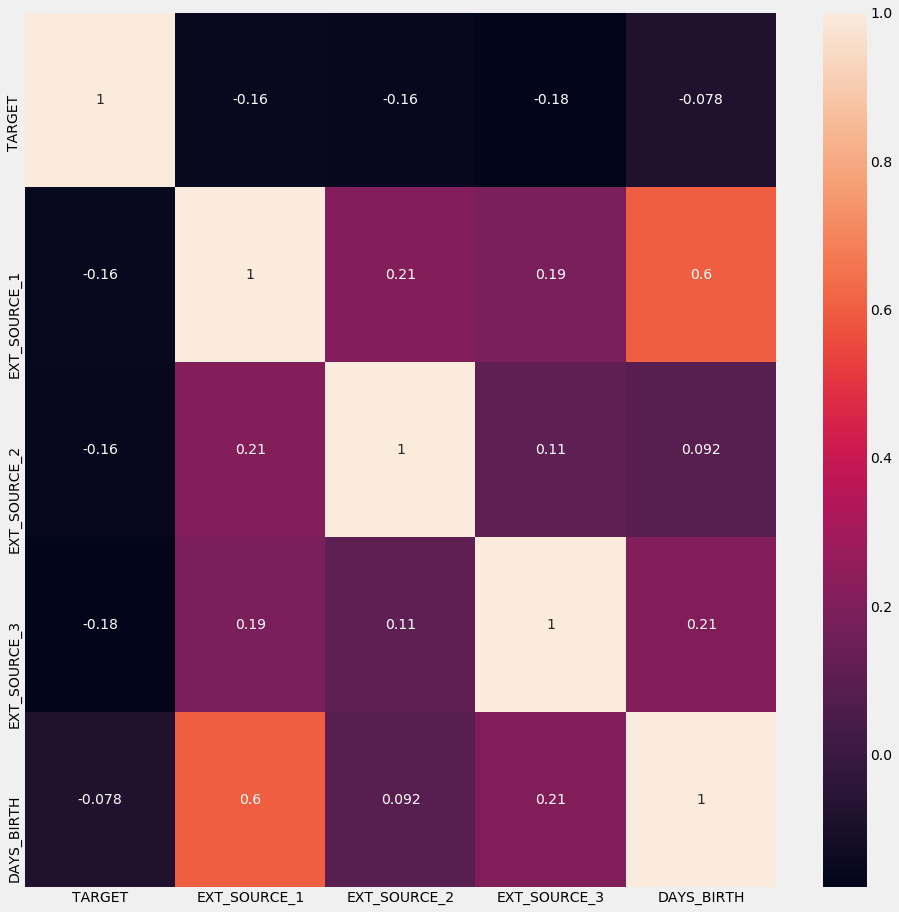

In [28]:
sns.heatmap(ext_data.corr(),annot = True)

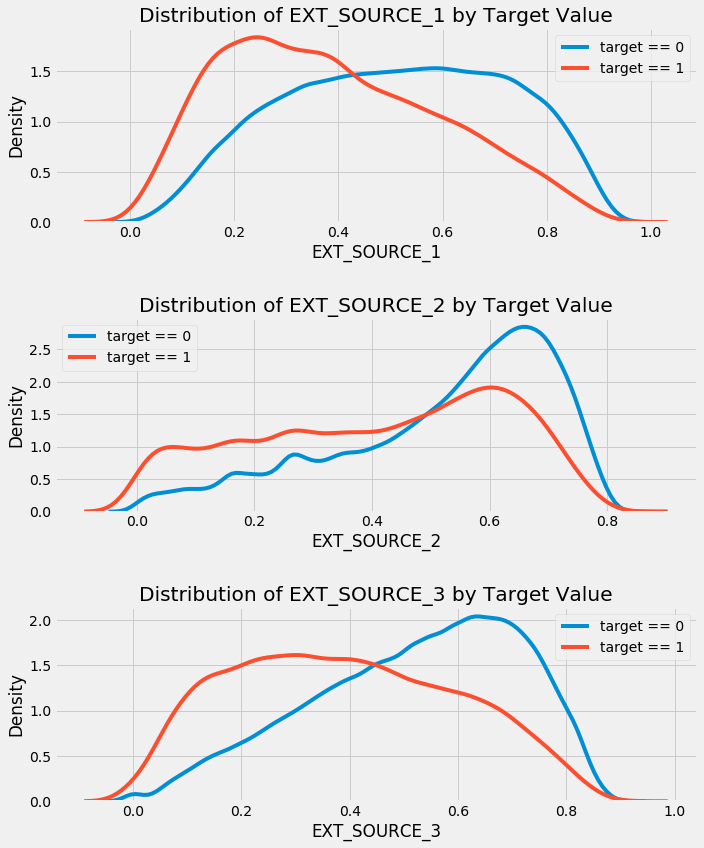

In [29]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The f

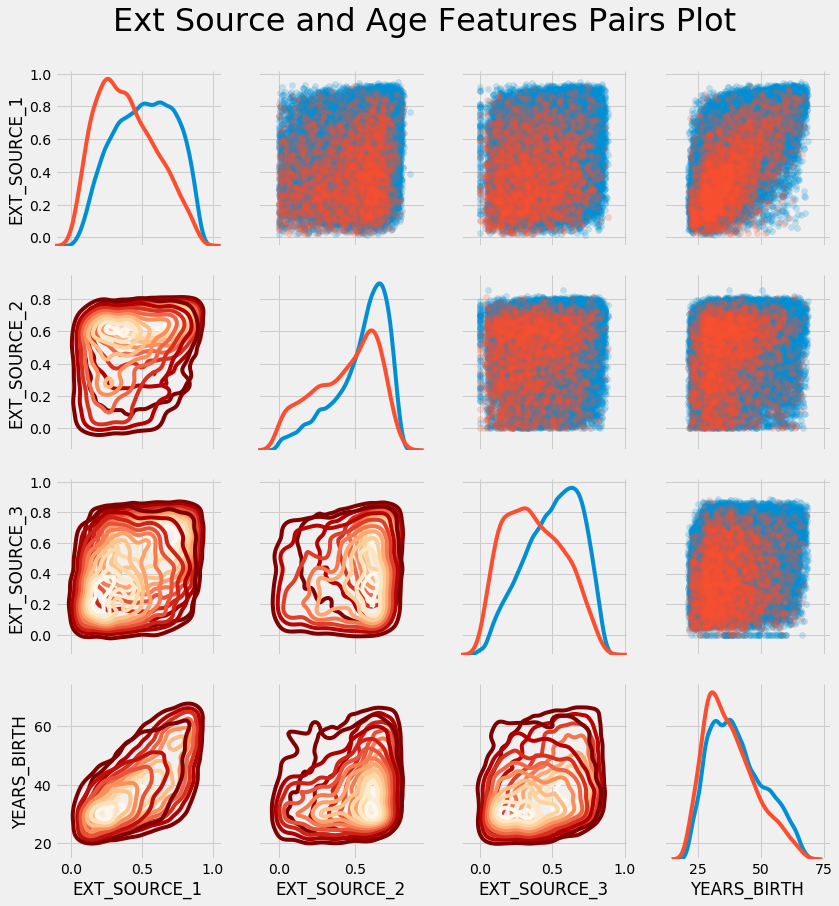

In [30]:
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In [31]:
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [32]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [33]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [34]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features,columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3', 'DAYS_BIRTH']))
# Add in the target
poly_features['TARGET'] = poly_target
# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()
# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [35]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


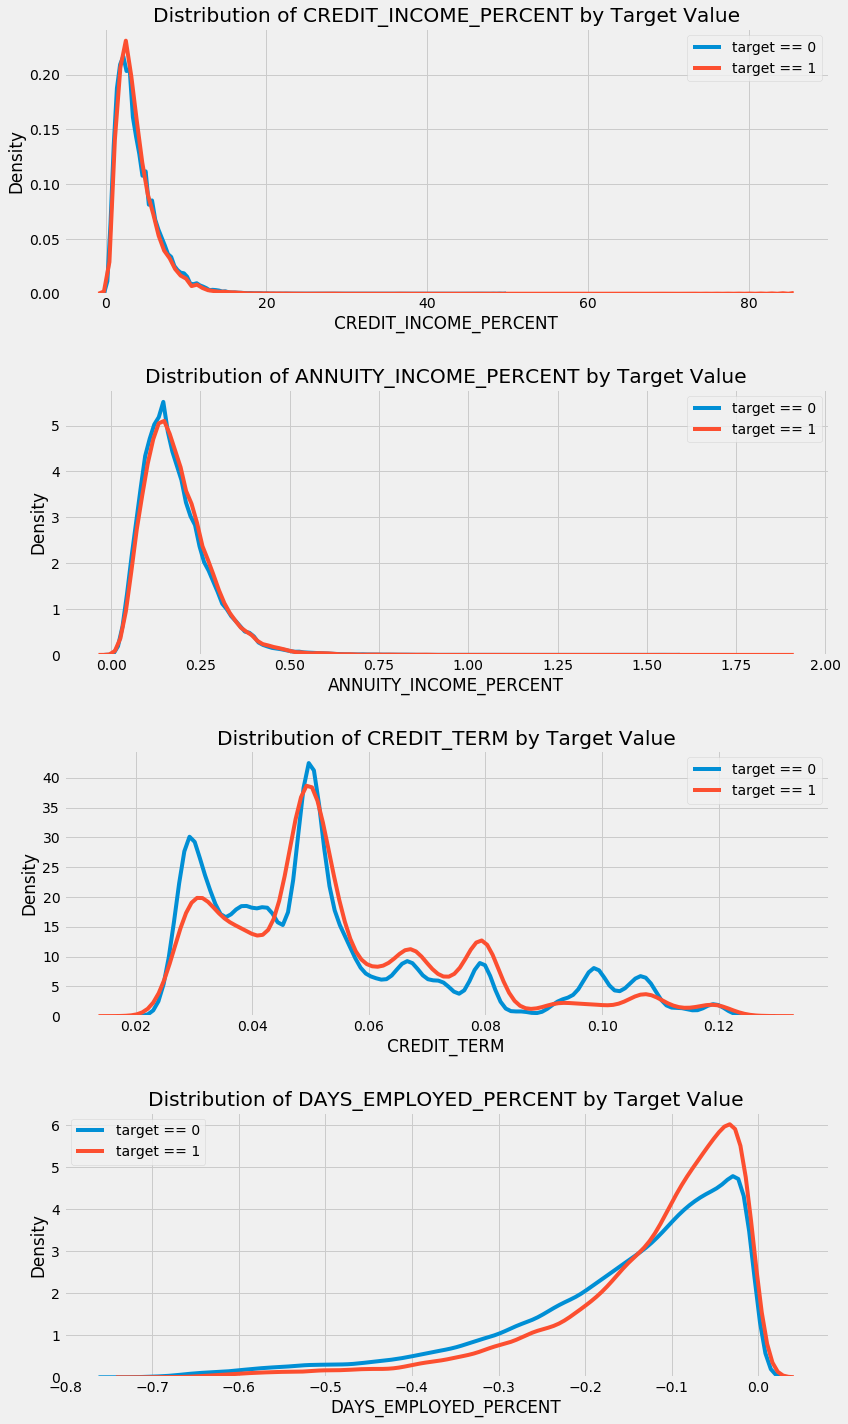

In [36]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [37]:
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))



In [38]:
# Fit on the training data
imputer.fit(train)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [39]:
train = imputer.transform(train)

In [40]:
train

array([[1.00002e+05, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00003e+05, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00004e+05, 1.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [4.56253e+05, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.56254e+05, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.56255e+05, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [48]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [49]:
train = scaler.transform(train)

In [42]:
# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)
X=train
y=train_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=425)
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


In [43]:
# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)
# Train on the training data
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [44]:
fpr, tpr, thresholds = roc_curve(y_test,log_reg.predict_proba(X_test)[:,1])
auc(fpr, tpr)

0.6758036672370618

In [45]:
log_reg.predict_proba(test)

array([[0.91126953, 0.08873047],
       [0.84839304, 0.15160696],
       [0.88583756, 0.11416244],
       ...,
       [0.92651914, 0.07348086],
       [0.90700779, 0.09299221],
       [0.89159218, 0.10840782]])

In [46]:
# Submission dataframe
#submit = app_test[['SK_ID_CURR']]
#submit['TARGET'] = log_reg_pred
#submit.to_csv('answer.csv',index=False)

In [47]:
log_reg.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)